# <h1 align = "center"> Keras Models</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. Inside this dataset, there are 25,000 labelled movies reviews for training, 50,000 unlabeled reviews for training, and 25,000 reviews for testing.
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Contains 25000 positive and 25000 negative reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)


This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow
> **Here, we use Keras Sequential API to train and test simple neural networks to classify sentiments of reviews by inputting tfidf features**

## <h2 align = "center">Dependencies</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Version:  1.13.1
Eager mode:  False
GPU is NOT AVAILABLE


In [2]:
'''
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

"\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [3]:
# for importing data from colab
# from google.colab import drive 
# drive.mount('/content/drive')

# movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/imdb_data.csv')
# movies.sample(7)

In [4]:
# read from local
movies = pd.read_csv('data/imdb_data.csv')
movies.sample(7)

,review,sentiment
36327,I watched this film not knowing anything about...,positive
40150,Unfortunately for myself - I stumbled onto thi...,positive
13388,I really am shocked to see the number of revie...,positive
28839,Pretty poor Firestarter clone that seems more ...,negative
40919,i searched video store everywhere to find this...,negative
32992,This show sucks. it was put on fridays on roll...,negative
9195,The world is made up two different types of mo...,positive


> **Binarize the sentiment column**

In [5]:
le = LabelEncoder()
movies['sentiment'] = le.fit_transform(movies['sentiment'])
movies.sample(7)

,review,sentiment
38016,The Cure uses voice over to create an intense ...,1
21165,I know a lot of people like this show and i ap...,0
26137,"Me being of Irish origins, loved this movie, N...",1
21556,You know I only watched 15 minutes of this fil...,0
29370,Direction must be the problem here. I recently...,0
43634,This is one of the best TV movies I have ever ...,1
8939,'Wicked Little Things' really separates itself...,1


 > **Vectorize the reviews text**

In [6]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

    transformed_texts = TfidfVectorizer(**kwargs).fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts

vect_reviews = ngram_vectorize(movies['review'], movies['sentiment'])
vect_reviews.shape

(50000, 20000)

> **Split the data**

In [7]:
X = vect_reviews.toarray()
y = (np.array(movies['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


## <h2 align = "center">Modeling the data</h2>

In [56]:
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, 
                              restore_best_weights=True)
sns.set()
def plot_learning_curve(hist):
    plt.figure(figsize=(5,5))
    train = hist.history['acc']
    val = hist.history['val_acc']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Accuracy')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Accuracy')
    plt.title("Accuracies vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [41]:
input_shape = X_train.shape[1:]

model = Sequential([    
    Dense(64, activation = 'relu', input_shape = input_shape),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 64)                1280064   
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [42]:
epochs = 20

h = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = [early_stop, simple_log],
    verbose = False)
print("\nDone.")

 ~| Epoch: 1 | Validation Loss: 0.18305 >|> 
 ~| Epoch: 2 | Validation Loss: 0.17350 >|> 
 ~| Epoch: 3 | Validation Loss: 0.19166 >|> 
 ~| Epoch: 4 | Validation Loss: 0.20891 >|> 

Done.


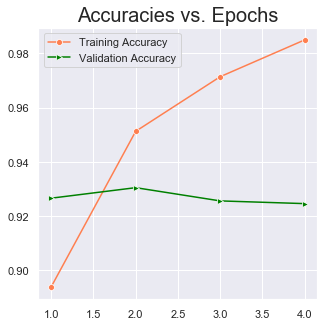

In [43]:
plot_learning_curve(h)

> **Classic case of overfitting**

In [44]:
loss, acc = model.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

10000/10000 [==============================] - 4s 362us/sample - loss: 0.1924 - acc: 0.9250
Testing Accuracy:  92.5000011920929


> **Trying dropout regularization**

In [13]:
input_shape = X_train.shape[1:]
from tensorflow.keras.regularizers import l2

model2 = Sequential([    
    Dense(20, activation = 'relu', input_shape = input_shape, kernel_regularizer=l2()),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model2.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                400020    
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 400,041
Trainable params: 400,041
Non-trainable params: 0
_________________________________________________________________


In [14]:
epochs = 10

h2 = model2.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = [early_stop, simple_log],
    verbose = False)
print("Done.")

 ~| Epoch: 1 | Validation Loss: 0.68045 >|> 
 ~| Epoch: 2 | Validation Loss: 0.64146 >|> 
 ~| Epoch: 3 | Validation Loss: 0.60731 >|> 
 ~| Epoch: 4 | Validation Loss: 0.58412 >|> 
 ~| Epoch: 5 | Validation Loss: 0.57064 >|> 
 ~| Epoch: 6 | Validation Loss: 0.54559 >|> 
 ~| Epoch: 7 | Validation Loss: 0.52379 >|> 
 ~| Epoch: 8 | Validation Loss: 0.51261 >|> 
 ~| Epoch: 9 | Validation Loss: 0.49817 >|> 
 ~| Epoch: 10 | Validation Loss: 0.48691 >|> 
Done.


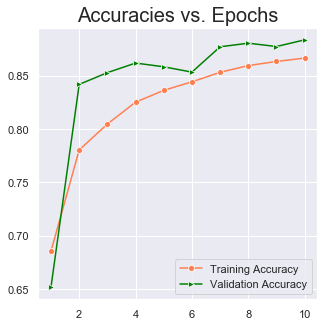

In [15]:
plot_learning_curve(h2)

In [16]:
loss, acc = model2.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

10000/10000 [==============================] - 6s 600us/sample - loss: 0.4948 - acc: 0.8817
Testing Accuracy:  88.16999793052673


In [17]:
input_shape = X_train.shape[1:]
from tensorflow.keras.regularizers import l2

model3 = Sequential([   
    Dense(64, activation = 'relu', input_shape = input_shape),
    Dropout(0.2),
    Dense(16, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model3.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 1,281,121
Trainable params: 1,281,121
Non-trainable params: 0
_________________________________________________________________


In [45]:
epochs = 20

h3 = model3.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = [early_stop, simple_log],
    verbose = False
)
print("\nDone.")

 ~| Epoch: 1 | Validation Loss: 0.18744 >|> 
 ~| Epoch: 2 | Validation Loss: 0.23030 >|> 
 ~| Epoch: 3 | Validation Loss: 0.28712 >|> 

Done.


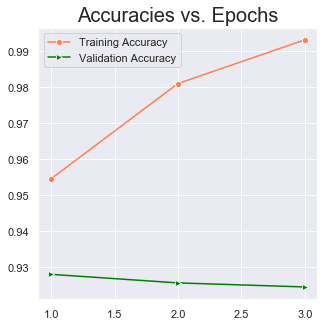

In [46]:
plot_learning_curve(h3)

In [47]:
loss, acc = model3.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

10000/10000 [==============================] - 3s 344us/sample - loss: 0.2063 - acc: 0.9227
Testing Accuracy:  92.26999878883362


### <h3 align = "center">Optimize activations and learning rate</h3>

In [21]:
def create_model(learning_rate=0.01, activation='relu'):
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
    model = Sequential()
    model.add(Dense(64, input_shape=input_shape, activation=activation)),
    Dropout(0.2),
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# Random Search is better than exhaustive search for hyperparameter tuning
# Import KerasClassifier from keras wrappers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV


# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model)

# Define the parameters to try out
params = {'activation': ['relu'],'epochs': [3, 5, 10], 
          'learning_rate': [0.1, 0.01, 0.001], 'batch_size': [64, 128, 256]}

# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model, param_distributions = params, cv = KFold(2))

Using TensorFlow backend.


In [23]:
# takes a lot of time ...
random_search.fit(X_train, y_train,
                  verbose = True)

Epoch 1/10
20000/20000 [==============================] - 10s 510us/sample - loss: 0.2570 - acc: 0.8898 - loss: 0
Epoch 2/10
20000/20000 [==============================] - 9s 458us/sample - loss: 0.0723 - acc: 0.9743
Epoch 3/10
20000/20000 [==============================] - 9s 452us/sample - loss: 0.0295 - acc: 0.9893
Epoch 4/10
20000/20000 [==============================] - 9s 465us/sample - loss: 0.0162 - acc: 0.9942
Epoch 5/10
20000/20000 [==============================] - 12s 590us/sample - loss: 0.0097 - acc: 0.9968
Epoch 6/10
20000/20000 [==============================] - 10s 501us/sample - loss: 0.0105 - acc: 0.9961
Epoch 7/10
20000/20000 [==============================] - 10s 483us/sample - loss: 0.0111 - acc: 0.9959
Epoch 8/10
20000/20000 [==============================] - 10s 479us/sample - loss: 0.0062 - acc: 0.9980
Epoch 9/10
20000/20000 [==============================] - 9s 457us/sample - loss: 0.0035 - acc: 0.9987
Epoch 10/10
20000/20000 [==============================] -

20000/20000 [==============================] - 10s 500us/sample - loss: 0.2976 - acc: 0.8616
Epoch 2/5
20000/20000 [==============================] - 9s 447us/sample - loss: 0.0964 - acc: 0.9657
Epoch 3/5
20000/20000 [==============================] - 9s 449us/sample - loss: 0.0620 - acc: 0.9799
Epoch 4/5
20000/20000 [==============================] - 9s 451us/sample - loss: 0.0378 - acc: 0.9879
Epoch 5/5
20000/20000 [==============================] - 5s 239us/sample - loss: 0.5668 - acc: 0.9018s - loss: 0.5708 - acc: 0.
Epoch 1/5
20000/20000 [==============================] - 11s 538us/sample - loss: 0.2822 - acc: 0.8873
Epoch 2/5
20000/20000 [==============================] - 9s 458us/sample - loss: 0.0985 - acc: 0.9667
Epoch 3/5
20000/20000 [==============================] - 9s 455us/sample - loss: 0.0505 - acc: 0.9857
Epoch 4/5
20000/20000 [==============================] - 9s 467us/sample - loss: 0.0483 - acc: 0.9870
Epoch 5/5
20000/20000 [==============================] - 5s 242u

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D6C8D142C8>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu'],
                                        'batch_size': [64, 128, 256],
                                        'epochs': [3, 5, 10],
                                        'learning_rate': [0.1, 0.01, 0.001]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [24]:
random_search.best_params_

{'learning_rate': 0.001, 'epochs': 3, 'batch_size': 256, 'activation': 'relu'}

In [25]:
best_random = random_search.best_estimator_ 
pred = best_random.predict(X_test)
pred_train = best_random.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  98.2175
Test set Accuracy:  92.73


In [26]:
def create_model(drop_out=0.2, units=64, learning_rate = 0.001):
    model = Sequential()
    model.add(Dropout(drop_out, input_shape=input_shape))
    model.add(Dense(units, activation = 'relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
model_params = KerasClassifier(build_fn = create_model)

params = {'drop_out': [0.2, 0.15, 0.1, 0.01], 'units': [60, 70, 90],
          'learning_rate': [0.001], 'batch_size': [128], 'epochs' : [5]}

# Create a randomize search cv object passing in the parameters to try
random_params = RandomizedSearchCV(model_params, param_distributions = params, cv = KFold(2))

In [28]:
# takes a lot of time ...
random_params.fit(X_train, y_train, verbose = True)

Epoch 1/5
20000/20000 [==============================] - 12s 611us/sample - loss: 0.5862 - acc: 0.8242
Epoch 2/5
20000/20000 [==============================] - 7s 374us/sample - loss: 0.3813 - acc: 0.8921
Epoch 3/5
20000/20000 [==============================] - 7s 370us/sample - loss: 0.2797 - acc: 0.9103
Epoch 4/5
20000/20000 [==============================] - 7s 369us/sample - loss: 0.2300 - acc: 0.9219
Epoch 5/5
20000/20000 [==============================] - 4s 187us/sample - loss: 0.2163 - acc: 0.9189
Epoch 1/5
20000/20000 [==============================] - 9s 446us/sample - loss: 0.5949 - acc: 0.8191s - loss: 0.6082 - 
Epoch 2/5
20000/20000 [==============================] - 7s 367us/sample - loss: 0.3908 - acc: 0.8887
Epoch 3/5
20000/20000 [==============================] - 7s 365us/sample - loss: 0.2878 - acc: 0.9068
Epoch 4/5
20000/20000 [==============================] - 7s 372us/sample - loss: 0.2350 - acc: 0.9217s
Epoch 5/5
20000/20000 [==============================] - 3s 1

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D6A62ECC48>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'batch_size': [128],
                                        'drop_out': [0.2, 0.15, 0.1, 0.01],
                                        'epochs': [5], 'learning_rate': [0.001],
                                        'units': [20, 40, 60]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [29]:
random_params.best_estimator_

In [30]:
random_params.best_params_

{'units': 60,
 'learning_rate': 0.001,
 'epochs': 5,
 'drop_out': 0.2,
 'batch_size': 128}

In [31]:
best_random = random_params.best_estimator_ 
pred = best_random.predict(X_test)
pred_train = best_random.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

Training set Accuracy:  97.46000000000001
Test set Accuracy:  92.83


In [59]:
input_shape = X_train.shape[1:]

model4 = Sequential([ 
    Dropout(0.2, input_shape=input_shape),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(lr=0.002)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_78 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_128 (Dense)            (None, 64)                1280064   
_________________________________________________________________
dropout_79 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [60]:
epochs = 150
batch_size = 128


h4 = model4.fit(X_train, y_train, epochs=epochs,
               validation_split = 0.2,
               callbacks=[early_stop, simple_log],
               verbose=False,
               batch_size=batch_size)
print("Done.")

 ~| Epoch: 1 | Validation Loss: 0.19927 >|> 
 ~| Epoch: 2 | Validation Loss: 0.17206 >|> 
 ~| Epoch: 3 | Validation Loss: 0.17024 >|> 
 ~| Epoch: 4 | Validation Loss: 0.17179 >|> 
Done.


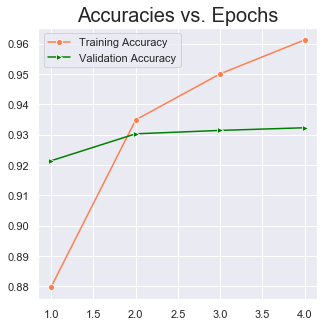

In [61]:
plot_learning_curve(h4)

In [62]:
loss, acc = model4.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

10000/10000 [==============================] - 7s 668us/sample - loss: 0.1904 - acc: 0.9243s - loss: 0.1883
Testing Accuracy:  92.43000149726868
